In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from tqdm import tqdm_notebook as tqdm
import datetime
# from meteocalc import feels_like, Temp
from sklearn import metrics
import gc
import os

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
def features_engineering(df):
    
    # Sort by timestamp
    df.sort_values("timestamp")
    df.reset_index(drop=True)
    
    # Add more features
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    df["hour"] = df["timestamp"].dt.hour
    df["dayofweek"] = df["timestamp"].dt.dayofweek
    
    df['month'] = df['timestamp'].dt.month
    df['month'].replace((1, 2, 3, 4), 1, inplace = True)
    df['month'].replace((5, 6, 7, 8), 2, inplace = True)
    df['month'].replace((9, 10, 11, 12), 3, inplace = True)
  
    df['square_feet'] =  np.log1p(df['square_feet'])
    
    # Remove Unused Columns
    drop = ["timestamp"]
    df = df.drop(drop, axis=1)
    gc.collect()
    
    # Encode Categorical Data
    le = LabelEncoder()
    df["primary_use"] = le.fit_transform(df["primary_use"])
    
    return df

In [9]:
# feature engineering
train_df = pd.read_csv('../../Large_output/train_df_new.csv')
train_df = features_engineering(train_df)

# transform target variable
train_df['meter_reading'] = np.log1p(train_df["meter_reading"])

In [10]:
# declare target, categorical and numeric columns
target = 'meter_reading'
categorical = ['building_id', 'site_id', 'primary_use', 'meter','dayofweek']
numeric_cols = [col for col in train_df.columns if col not in categorical + [target, 'timestamp', 'month']]
features = categorical + numeric_cols

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.21966	valid_1's rmse: 1.22397
[50]	training's rmse: 0.876588	valid_1's rmse: 0.895772
[75]	training's rmse: 0.748348	valid_1's rmse: 0.786597
[100]	training's rmse: 0.690031	valid_1's rmse: 0.745456
[125]	training's rmse: 0.654288	valid_1's rmse: 0.727667
[150]	training's rmse: 0.631523	valid_1's rmse: 0.719552
[175]	training's rmse: 0.615182	valid_1's rmse: 0.716205
[200]	training's rmse: 0.601543	valid_1's rmse: 0.713926
[225]	training's rmse: 0.589554	valid_1's rmse: 0.712322
[250]	training's rmse: 0.579262	valid_1's rmse: 0.711997
[275]	training's rmse: 0.570304	valid_1's rmse: 0.711743
[300]	training's rmse: 0.562908	valid_1's rmse: 0.711816
[325]	training's rmse: 0.556624	valid_1's rmse: 0.711945
Early stopping, best iteration is:
[284]	training's rmse: 0.567472	valid_1's rmse: 0.711653
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.20836	valid_1's rmse: 1.26

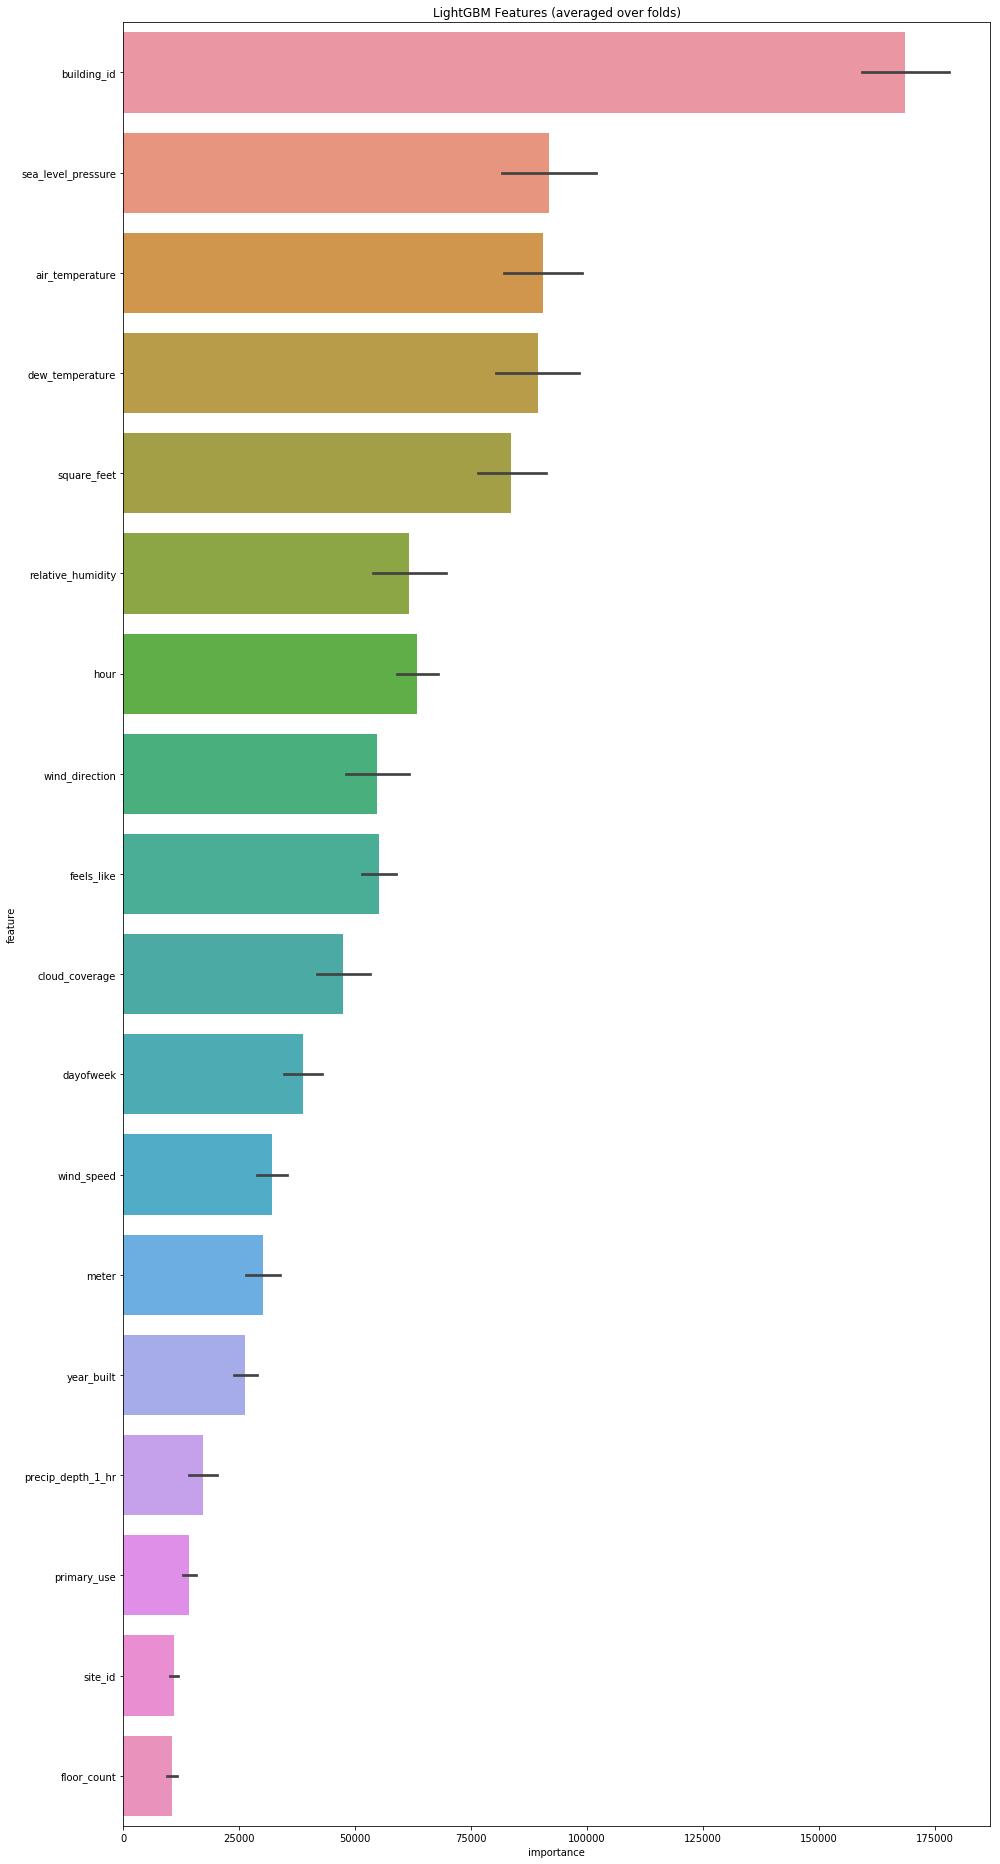

In [11]:
import seaborn as sns

def run_lgbm(train, cat_features = categorical, num_rounds = 20000, folds = 5):
    kf = StratifiedKFold(n_splits=folds, shuffle=False, random_state=2319)
    models = []
    feature_importance_df = pd.DataFrame()

    param =  {'num_leaves': 3160,
             'objective': 'regression',
             'learning_rate': 0.03,
             'boosting': 'gbdt',
             'subsample': 0.5,
             'feature_fraction': 0.7,
             'n_jobs': -1,
             'seed': 50,
             'metric': 'rmse'
              }
    
    oof = np.zeros(len(train))
  
    for tr_idx, val_idx in tqdm(kf.split(train_df,train_df['month']), total = folds):
        tr_x, tr_y = train[features].iloc[tr_idx], train[target].iloc[tr_idx]
        vl_x, vl_y = train[features].iloc[val_idx], train[target].iloc[val_idx]
        tr_data = lgb.Dataset(tr_x, label = tr_y,  categorical_feature = categorical)
        vl_data = lgb.Dataset(vl_x, label = vl_y,  categorical_feature = categorical)
        clf = lgb.train(param, tr_data, num_rounds, valid_sets = [tr_data, vl_data], verbose_eval = 25, 
                        early_stopping_rounds = 50)
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        models.append(clf)
        oof[val_idx] = clf.predict(vl_x)
        gc.collect()
    score = np.sqrt(metrics.mean_squared_error(train[target], np.clip(oof, a_min=0, a_max=None)))
    print('Our oof cv is :', score)
    
    cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:20].index)
    best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

    plt.figure(figsize=(14,26))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
    plt.title('LightGBM Features (averaged over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

    return models
models = run_lgbm(train_df)

In [12]:
# read test
test_df = pd.read_csv('../../Large_output/test_df_new.csv')
row_ids = test_df["row_id"]
# feature engineering
test_df = features_engineering(test_df)

Memory usage of dataframe is 954.38 MB
Memory usage after optimization is: 199.59 MB
Decreased by 79.1%


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


Memory usage of dataframe is 23.53 MB
Memory usage after optimization is: 11.18 MB
Decreased by 52.5%


In [13]:
def predictions(models, iterations = 120):
    # split test data into batches
    set_size = len(test_df)
    batch_size = set_size // iterations
    meter_reading = []
    for i in tqdm(range(iterations)):
        pos = i*batch_size
        fold_preds = [np.expm1(model.predict(test_df[features].iloc[pos : pos+batch_size])) for model in models]
        meter_reading.extend(np.mean(fold_preds, axis=0))

    print(len(meter_reading))
    assert len(meter_reading) == set_size
    submission = pd.read_csv('../../Resources/sample_submission.csv')
    submission['meter_reading'] = np.clip(meter_reading, a_min=0, a_max=None) # clip min at zero
    submission.to_csv('fe2_lgbm.csv', index=False)
    print('We are done!')
predictions(models)


41697600
We are done!
